In [327]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/../RKLM_Python/')
from data_assimilation import letkf
from scipy.linalg import sqrtm

import importlib
importlib.reload(letkf)
%matplotlib inline

In [328]:
sigm = 10.
rho = 28.
beta = 8./3
dt = 0.001
Nout = int(50)
a = 1. / np.sqrt(dt)
fakt = 1.99999
N = int(2 * 10**5)

# initial conditions
x = -.587
y = -.563
z = 16.870
g1 = a * (1. / np.sqrt(2.) - .5)
g2 = a * (1. / np.sqrt(3.) - .5)
g3 = a * (1. / np.sqrt(5.) - .5)
res = np.zeros((N,7))

def gi(gi):
    if ((gi >= -a/2) and gi < 0):
        return a * (fakt * gi / a + 0.5)
    else:
        return a * (-fakt * gi / a + 0.5)
        
for i in range(N):
    res[i,:] = [i, x, y, z, g1, g2, g3]
    
    g1 = gi(g1)
    g2 = gi(g2)
    g3 = gi(g3)
    
    xn = x + dt * (sigm * (y - x)) + dt * g1
    yn = y + dt * (x * (rho - z) - y) + dt * g2
    zn = z + dt * (x * y - beta * z) + dt * g3
    
    x, y, z = xn, yn, zn
    
res[:,0] *= dt

# store only points with dt = 0.05
ressug = res[::Nout]

# add measurement error using tent map
meas = np.zeros((int(N)*4,2))
a = 4.
fakt = 1.99999
eta1 = a * (2.**(-1./2) - 0.5)

for i in range(N*4):
    if ((eta1 >= -a/2) and (eta1 < 0)):
        eta1 = (fakt * eta1 + 0.5 * a)
    else:
        eta1 = (-fakt * eta1 + 0.5 * a)
    meas[i] = [i+1, eta1]
    
measerr = meas[:,1][::10]

# observation of x-component (dt = 0.05, first 200 datapoints)
obsx = np.zeros((int(N/Nout),3))
j = 0
i = 0

for k in range(0,N,Nout):
    err = 1./20 * np.sum(measerr[j:j+20])
    obsx[i] = [res[k,0], res[k,1], err]
    i += 1
    j += 20
    
obsx = np.array(obsx)
obs = [obsx[:,0], obsx[:,1] + obsx[:,2]]
obs = np.array(obs)

In [329]:
def enkf_simple():
    None
    
# def forward_operator(X,R,M):
#     tmp = np.zeros_like(X.T)
#     print("tmp.shape = ", tmp.shape)
#     tmp[:,0] += np.sqrt(R) * np.random.randn(M)
#     print("tmp = ", tmp)
#     return lambda X : X + tmp

def forward_operator(X):
    return X[:,0]



In [330]:
STEPS = 5*40
R = 1./15

# recall that from example 4.8, the Lorenz model with drift term f(x) set to zero can be modelled 
# by a stochastic difference equation with mean = 0, var = 0.0838.
var = 0.0838

# sigma value given in example 6.9.
sigma = 0.1

NN = 20
m = np.arange(1,NN+1)
m = 2*m

lenm = len(m)

#m = np.array([4])

rmse_x = np.zeros((lenm))
rmse_y = np.zeros((lenm))
rmse_z = np.zeros((lenm))

for lkl in range(lenm):
    M = m[lkl]
    
    x0 = -0.587
    y0 = -0.563
    z0 = 16.87
    
    x = x0 + np.sqrt(sigma) * np.random.randn(M)
    y = y0 + np.sqrt(sigma) * np.random.randn(M)
    z = z0 + np.sqrt(sigma) * np.random.randn(M)
    t= np.zeros((STEPS+1))
    
    x_f = np.zeros((STEPS+1))
    y_f = np.zeros((STEPS+1))
    z_f = np.zeros((STEPS+1))
    
    x_f[0] = np.mean(x)
    y_f[0] = np.mean(y)
    z_f[0] = np.mean(z)
    
    rmse_x[lkl] = 0.
    rmse_y[lkl] = 0.
    rmse_z[lkl] = 0.
    
    cnt = 0
    
    for j in range(STEPS):
        xh = x
        yh = y
        zh = z
        
        for i in range(Nout):
            xo = xh
            yo = yh
            zo = zh
            
            # step within each observation window by means of the stochastic Lorenz-63 model
            xh = xo + dt * 10. * (yo-xo) + np.sqrt(dt * var) * np.random.randn(M)
            yh = yo + dt * (xo * (28. - zo) - yo) + np.sqrt(dt * var) * np.random.randn(M)
            zh = zo + dt * (xo * yo - 8./3 * zo) + np.sqrt(dt * var) * np.random.randn(M)
        
        x = xh
        y = yh
        z = zh
        
        X = np.vstack((x,y,z))
#         print("State space mean in 3 coords = ", X.mean(axis=1))
#         print("Observation = ", obs[1,j+1])
        
#         obs_current = obs[1,j+1] + np.sqrt(R) * np.random.randn(M)

#         obs_current = np.array([obs[1,j+1],0.,0.]).reshape(-1,1)
        obs_current = np.array([obs[1,j+1]]).reshape(1,-1)
    
        analysis = letkf.analysis(X.T)
        forward_op = forward_operator
#         forward_op = forward_operator(X,R,M)
        analysis.forward_operator = forward_op
#         R_sp = np.diag([np.inf] * len(obs_current))
#         R_sp = np.zeros_like(np.ones((len(obs_current),len(obs_current))))
#         R_sp[0,0] = R
        R_sp = np.array([R]).reshape(1,1)
#         R_sp = np.ones((len(obs_current),len(obs_current))) * R
        X = analysis.analyse(obs_current,R_sp)

###################################EnKF-PO#####################################

        # Calculate residual: (forward map of reference - yobs)
#         r = xh - obs[1,j+1]

#         # Hz^f_i + eta_i - y_{obs} = rpert
#         rpert = r + np.sqrt(R) * np.random.randn(M)
#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         P = P.sum(axis=1)/(M-1)
#         K = P[:,0] / (P[0,0] + R)
#         X -= np.outer(K,rpert)

###################################ESRF#######################################

#         dX = X - np.mean(X, axis=1).reshape(-1,1)

#         P = dX[:,:,None] * dX.T[None,:,:]
#         print("P.shape = dX * dX.T = ", P.shape)
#         P = P.sum(axis=1)/(M-1)
#         print("P.shape after sum = ", P.shape)
        
        
#         K = P[:,0] / (P[0,0] + R)
#         print("K.shape = ", K.shape)
        
#         # mean of analysis, eqn 7.8
#         xmean = np.mean(X,axis=1)
#         xmean = xmean - K*(xmean[0] - obs[1,j+1])
        
#         # Get the S matrix, eqn 7.22
#         Y = dX[0,:] / np.sqrt(M-1)
#         Y = Y.reshape(-1,1) # to make transpose sensible - 1D arrays not transposable!
#         S2 = np.linalg.inv(sqrtm(np.eye(M) + Y.T * Y / R)).real
#         dX = np.dot(dX,S2)
        
#         X = xmean.reshape(-1,1) * np.ones(1,M) + dX
        
##############################################################################

        x = X[0,:]
        y = X[1,:]
        z = X[2,:]
        
        x_f[j+1] = np.mean(x)
        y_f[j+1] = np.mean(y)
        z_f[j+1] = np.mean(z)
        t[j+1] = dt * Nout * (j+1)
        
        rmse_x[lkl] = rmse_x[lkl] + (x_f[j+1] - ressug[j+1,1])**2
        rmse_y[lkl] = rmse_y[lkl] + (y_f[j+1] - ressug[j+1,2])**2
        rmse_z[lkl] = rmse_z[lkl] + (z_f[j+1] - ressug[j+1,3])**2
        
    rmse_x[lkl] = np.sqrt(rmse_x[lkl] / STEPS)
    rmse_y[lkl] = np.sqrt(rmse_y[lkl] / STEPS)
    rmse_z[lkl] = np.sqrt(rmse_z[lkl] / STEPS)


self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [0.00000000e+00 5.55111512e-17 0.00000000e+00]
Sanity check #2, sum of columns of wa: [0.00000000e+00 4.16333634e-17 0.00000000e+00]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [-1.11022302e-16 -1.11022302e-16  0.00000000e+00]
Sanity check #2, sum of columns of wa: [-9.71445147e-17 -8.32667268e-17 -1.38777878e-17]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [1.11022302e-16 0.00000000e+00 0.00000000e+00]
Sanity check #2, sum of columns of wa: [ 1.11022302e-16 -5.55111512e-17  6.93889390e-18]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [0.00000000e+00 4.44089210e-16 1.77635684e-15]
Sanity check #2, sum of columns of wa: [0.00000000e+00 4.44089210e-16 1.77646526e-15]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [2.22044605e-16 4.4

self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [ 1.11022302e-16 -1.11022302e-16  0.00000000e+00]
Sanity check #2, sum of columns of wa: [ 5.55111512e-17 -1.52655666e-16  3.46944695e-18]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [5.55111512e-17 0.00000000e+00 0.00000000e+00]
Sanity check #2, sum of columns of wa: [6.93889390e-17 2.77555756e-17 2.77555756e-17]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -5.55111512e-17 -1.77635684e-15]
Sanity check #2, sum of columns of wa: [ 0.00000000e+00 -5.55111512e-17 -1.76247905e-15]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [-1.11022302e-16  0.00000000e+00  0.00000000e+00]
Sanity check #2, sum of columns of wa: [-1.11022302e-16  5.55111512e-17  1.38777878e-17]
self.no_of_members =  2
self.X.shape =  (2, 3)
Sanity check # 1, sum of columns of X =  [0.0000000

self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 3.33066907e-16 -2.22044605e-16  0.00000000e+00]
Sanity check #2, sum of columns of wa: [ 2.71484224e-16 -3.88578059e-16  5.55111512e-17]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [-2.22044605e-16  8.88178420e-16  3.55271368e-15]
Sanity check #2, sum of columns of wa: [-2.49800181e-16  8.32667268e-16  3.55271368e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [0. 0. 0.]
Sanity check #2, sum of columns of wa: [ 2.77555756e-17 -1.11022302e-16  1.11022302e-16]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [-6.66133815e-16 -4.44089210e-16  1.77635684e-15]
Sanity check #2, sum of columns of wa: [-3.88578059e-16  5.55111512e-17  1.72084569e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 1.33226763e-15 -1.77635684e-15 -1.7763568

Sanity check #2, sum of columns of wa: [-1.66533454e-16 -3.33066907e-16  7.12277459e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00  2.22044605e-16 -1.77635684e-15]
Sanity check #2, sum of columns of wa: [ 0.00000000e+00  1.94289029e-16 -1.77635684e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 1.11022302e-15  1.77635684e-15 -5.32907052e-15]
Sanity check #2, sum of columns of wa: [ 6.38378239e-16  1.05471187e-15 -5.23192600e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 2.22044605e-15 -1.77635684e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [ 1.60982339e-15 -2.77555756e-15 -3.30291350e-15]
self.no_of_members =  4
self.X.shape =  (4, 3)
Sanity check # 1, sum of columns of X =  [ 8.88178420e-16  0.00000000e+00 -1.77635684e-15]
Sanity check #2, sum of columns of wa: [ 6.66133815e-16 -3.88578059e-16 -1.55431223e-15]
sel

Sanity check #2, sum of columns of wa: [-1.72084569e-15  2.33146835e-15  3.30291350e-15]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  3.55271368e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [-1.11022302e-15  4.66293670e-15 -3.99680289e-15]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15 -2.48689958e-14 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [-1.27675648e-15 -2.41473508e-14 -1.11022302e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [ 1.42108547e-14  3.55271368e-15 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 1.06581410e-14  1.05471187e-15 -2.22044605e-15]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.42108547e-14  0.00000000e+00 -2.84217094e-14]
Sanity check #2, sum of columns of wa: [-1.22003102e-14  9.43689571e-16 -3.25295346e-14]
sel

self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [ 6.66133815e-16 -6.66133815e-16  0.00000000e+00]
Sanity check #2, sum of columns of wa: [ 5.34294831e-16 -7.33788030e-16  5.55111512e-17]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [ 4.44089210e-16 -1.11022302e-16 -1.77635684e-14]
Sanity check #2, sum of columns of wa: [ 3.92047506e-16 -1.59594560e-16 -1.77080572e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-2.22044605e-16  2.22044605e-16 -8.88178420e-15]
Sanity check #2, sum of columns of wa: [-2.25514052e-16  8.32667268e-17 -8.87484530e-15]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15 -1.33226763e-15  1.06581410e-14]
Sanity check #2, sum of columns of wa: [-1.56819002e-15 -9.43689571e-16  1.06060993e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.

self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  8.88178420e-15  1.42108547e-14]
Sanity check #2, sum of columns of wa: [-1.52655666e-15  9.15933995e-15  1.40720768e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-3.55271368e-15  5.32907052e-15  3.55271368e-15]
Sanity check #2, sum of columns of wa: [-2.83106871e-15  5.96744876e-15  2.66453526e-15]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-5.32907052e-15 -7.10542736e-15 -1.77635684e-14]
Sanity check #2, sum of columns of wa: [-4.16333634e-15 -6.13398221e-15 -1.93178806e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [ 8.88178420e-15 -7.10542736e-15 -1.42108547e-14]
Sanity check #2, sum of columns of wa: [ 8.07687250e-15 -7.36910533e-15 -1.21569421e-14]
self.no_of_members =  6
self.X.shape =  (6, 3)
Sanity check # 1, sum of columns of X =  [-1.

Sanity check #2, sum of columns of wa: [-6.66133815e-16  1.77635684e-15 -1.43773882e-14]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [ 3.10862447e-15  4.44089210e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [ 3.01147995e-15  4.44089210e-15 -3.44169138e-15]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [-6.21724894e-15 -7.10542736e-15 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [-6.57807142e-15 -7.60502772e-15 -1.00475184e-14]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [-2.66453526e-15  1.77635684e-15 -1.77635684e-14]
Sanity check #2, sum of columns of wa: [-3.88578059e-15  1.11022302e-16 -1.67088565e-14]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [-1.06581410e-14  8.88178420e-15  1.42108547e-14]
Sanity check #2, sum of columns of wa: [-1.12132525e-14  8.32667268e-15  1.54321000e-14]
sel

self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [4.44089210e-15 6.21724894e-15 1.77635684e-14]
Sanity check #2, sum of columns of wa: [4.71844785e-15 6.43929354e-15 1.77358128e-14]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -1.77635684e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [-5.55111512e-17 -1.60982339e-15 -3.44169138e-15]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [ 1.77635684e-15 -4.44089210e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [ 1.52655666e-15 -4.63518113e-15 -3.38618023e-15]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  8.88178420e-15  1.42108547e-14]
Sanity check #2, sum of columns of wa: [-1.74860126e-15  8.97892871e-15  1.42108547e-14]
self.no_of_members =  8
self.X.shape =  (8, 3)
Sanity check # 1, sum of columns of X =  [-5.329070

self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [-2.22044605e-15  8.88178420e-16 -5.32907052e-14]
Sanity check #2, sum of columns of wa: [-2.47024623e-15  5.96744876e-16 -5.31519273e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [-7.54951657e-15  4.44089210e-15  3.55271368e-14]
Sanity check #2, sum of columns of wa: [-7.67441666e-15  4.02802791e-15  3.55826479e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [-2.66453526e-15 -1.77635684e-15 -2.84217094e-14]
Sanity check #2, sum of columns of wa: [-2.27595720e-15 -1.20042865e-15 -2.89282487e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [ 8.88178420e-16  1.86517468e-14 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 6.22765728e-16  1.85060300e-14 -1.05193632e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-14 -7.10542736e-15  0.00000000e+00]
Sanity check #2, sum of columns of wa: [-1.58484337e-14 -6.24500451e-15 -3.08086889e-15]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15 -1.95399252e-14  2.84217094e-14]
Sanity check #2, sum of columns of wa: [-1.78503046e-15 -1.95399252e-14  2.83818108e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00  3.55271368e-15 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 0.00000000e+00  3.85802501e-15 -1.05193632e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -3.55271368e-15  4.61852778e-14]
Sanity check #2, sum of columns of wa: [ 5.55111512e-17 -3.85802501e-15  4.61575222e-14]
self.no_of_members =  10
self.X.shape =  (10, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [-4.99600361e-16  9.76996262e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [-5.27355937e-16  9.75608483e-15 -3.45556916e-15]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [8.88178420e-16 1.77635684e-14 1.42108547e-14]
Sanity check #2, sum of columns of wa: [9.02056208e-16 1.78121407e-14 1.41969769e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [-5.32907052e-15  4.44089210e-15 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [-5.06539255e-15  4.82947016e-15 -3.60267371e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-15 -2.66453526e-15  7.10542736e-15]
Sanity check #2, sum of columns of wa: [ 5.71764858e-15 -2.19269047e-15  6.28663788e-15]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  

Sanity check #2, sum of columns of wa: [-3.52495810e-15 -2.97938757e-16 -1.09148801e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [-1.55431223e-15  3.55271368e-15 -1.77635684e-14]
Sanity check #2, sum of columns of wa: [-1.26981758e-15  3.66373598e-15 -1.78915043e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [5.77315973e-15 8.88178420e-16 3.90798505e-14]
Sanity check #2, sum of columns of wa: [5.24580379e-15 3.60822483e-16 3.96072064e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [ 8.88178420e-16 -6.21724894e-15 -1.42108547e-14]
Sanity check #2, sum of columns of wa: [ 6.14092110e-16 -6.41847686e-15 -1.36834988e-14]
self.no_of_members =  12
self.X.shape =  (12, 3)
Sanity check # 1, sum of columns of X =  [ 1.77635684e-15 -9.76996262e-15 -4.97379915e-14]
Sanity check #2, sum of columns of wa: [ 1.59074143e-15 -9.87404603e-15 -4.94881913e-14]
s

Sanity check #2, sum of columns of wa: [ 1.24900090e-16 -6.66133815e-16  3.58602037e-14]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [ 1.22124533e-15 -6.66133815e-16  6.39488462e-14]
Sanity check #2, sum of columns of wa: [ 9.15933995e-16 -1.05471187e-15  6.36019015e-14]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [-2.22044605e-16 -6.66133815e-16  3.19744231e-14]
Sanity check #2, sum of columns of wa: [-1.38777878e-16 -6.66133815e-16  3.18634008e-14]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [-3.88578059e-16  7.77156117e-16  3.55271368e-15]
Sanity check #2, sum of columns of wa: [-4.44089210e-16  5.55111512e-16  3.88578059e-15]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [-4.44089210e-16 -2.22044605e-16  1.42108547e-14]
Sanity check #2, sum of columns of wa: [-8.32667268e-17  2.22044605e-16  1.42663659e

Sanity check #2, sum of columns of wa: [-8.32667268e-17  3.88578059e-16  5.44009282e-15]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [-4.44089210e-16 -2.60902411e-15  2.48689958e-14]
Sanity check #2, sum of columns of wa: [ 8.32667268e-17 -2.08166817e-15  2.46747067e-14]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  0.00000000e+00 -7.10542736e-15]
Sanity check #2, sum of columns of wa: [-1.13797860e-15  1.11022302e-15 -6.99613978e-15]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [ 2.22044605e-15 -7.99360578e-15  2.39808173e-14]
Sanity check #2, sum of columns of wa: [ 2.41473508e-15 -7.91033905e-15  2.41404119e-14]
self.no_of_members =  14
self.X.shape =  (14, 3)
Sanity check # 1, sum of columns of X =  [2.44249065e-15 1.24344979e-14 3.55271368e-15]
Sanity check #2, sum of columns of wa: [1.26287869e-15 1.03250741e-14 3.23352456e-15]
s

self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [ 1.77635684e-15 -1.86517468e-14  3.55271368e-15]
Sanity check #2, sum of columns of wa: [ 1.52655666e-15 -1.90403249e-14  3.55271368e-15]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [-7.99360578e-15  1.06581410e-14  8.88178420e-15]
Sanity check #2, sum of columns of wa: [-6.38378239e-15  1.32116540e-14  1.06581410e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [ 3.90798505e-14  3.73034936e-14 -3.19744231e-14]
Sanity check #2, sum of columns of wa: [ 3.66928710e-14  3.44169138e-14 -3.63042929e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [-3.73034936e-14 -1.06581410e-14  8.88178420e-14]
Sanity check #2, sum of columns of wa: [-4.08839629e-14 -1.31006317e-14  8.19344592e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [7.99360578e-15 7.10542736e-15 2.66453526e-14]
Sanity check #2, sum of columns of wa: [7.54951657e-15 6.88338275e-15 2.67563749e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [-4.44089210e-15 -1.42108547e-14  2.84217094e-14]
Sanity check #2, sum of columns of wa: [-7.16093851e-15 -1.89848137e-14  3.13082893e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [-3.55271368e-15  0.00000000e+00  1.06581410e-14]
Sanity check #2, sum of columns of wa: [-2.55351296e-15  1.83186799e-15  9.10382880e-15]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [7.10542736e-15 0.00000000e+00 2.48689958e-14]
Sanity check #2, sum of columns of wa: [ 5.71764858e-15 -1.19348975e-15  2.70894418e-14]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [8.

self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-15  1.77635684e-15 -7.10542736e-15]
Sanity check #2, sum of columns of wa: [ 4.82947016e-15  2.22044605e-15 -5.55111512e-15]
self.no_of_members =  16
self.X.shape =  (16, 3)
Sanity check # 1, sum of columns of X =  [-8.88178420e-15  0.00000000e+00  1.13686838e-13]
Sanity check #2, sum of columns of wa: [-8.10462808e-15  3.33066907e-16  1.13020704e-13]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-1.22124533e-15  9.99200722e-16  7.99360578e-14]
Sanity check #2, sum of columns of wa: [-1.24900090e-15  6.66133815e-16  7.92005350e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-5.55111512e-17  4.44089210e-15 -2.13162821e-14]
Sanity check #2, sum of columns of wa: [-2.77555756e-16  3.60822483e-15 -2.08062734e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of

Sanity check #2, sum of columns of wa: [ 1.56888391e-14 -3.33951616e-14 -6.97220059e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-3.01980663e-14 -1.59872116e-14 -5.32907052e-14]
Sanity check #2, sum of columns of wa: [-2.40276549e-14 -1.14352972e-14 -6.53088694e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-15 -4.61852778e-14  2.84217094e-14]
Sanity check #2, sum of columns of wa: [ 4.60742555e-15 -4.67542671e-14  2.95319325e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [ 2.13162821e-14 -2.84217094e-14  2.84217094e-14]
Sanity check #2, sum of columns of wa: [ 2.24681385e-14 -2.69367861e-14  2.79359869e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-5.32907052e-15  4.44089210e-14 -2.84217094e-14]
Sanity check #2, sum of columns of wa: [-4.37497261e-15  4.59632332e-14 -2.99205105e

self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -5.32907052e-15 -4.61852778e-14]
Sanity check #2, sum of columns of wa: [ 1.94289029e-16 -5.99520433e-15 -4.71012118e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-9.76996262e-15 -4.88498131e-15 -5.32907052e-14]
Sanity check #2, sum of columns of wa: [-1.05471187e-14 -5.49560397e-15 -5.34572386e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-1.68753900e-14 -2.66453526e-15  6.03961325e-14]
Sanity check #2, sum of columns of wa: [-1.67366121e-14 -2.58126853e-15  6.02851102e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of X =  [-1.95399252e-14  2.22044605e-14 -6.03961325e-14]
Sanity check #2, sum of columns of wa: [-1.94289029e-14  2.20518048e-14 -6.06736883e-14]
self.no_of_members =  18
self.X.shape =  (18, 3)
Sanity check # 1, sum of columns of

Sanity check #2, sum of columns of wa: [-1.60427227e-14  2.23709939e-14 -1.14352972e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [-7.10542736e-15  1.06581410e-14 -7.81597009e-14]
Sanity check #2, sum of columns of wa: [-6.27276009e-15  1.18238752e-14 -8.06021916e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [ 7.10542736e-14 -3.01980663e-14  4.97379915e-14]
Sanity check #2, sum of columns of wa: [ 6.81676937e-14 -3.06421555e-14  5.62883073e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [-5.32907052e-15  3.73034936e-14  4.26325641e-14]
Sanity check #2, sum of columns of wa: [-4.81559237e-15  3.79696274e-14  4.25770530e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [ 2.13162821e-14  1.95399252e-14 -1.06581410e-13]
Sanity check #2, sum of columns of wa: [ 1.88182803e-14  1.47659662e-14 -1.05795581e

self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  7.10542736e-15 -9.23705556e-14]
Sanity check #2, sum of columns of wa: [-1.50227053e-15  7.57727214e-15 -9.36195566e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [ 8.88178420e-15 -8.88178420e-16 -2.48689958e-14]
Sanity check #2, sum of columns of wa: [ 7.72992781e-15 -1.60982339e-15 -2.33701947e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [-2.57571742e-14  0.00000000e+00 -3.19744231e-14]
Sanity check #2, sum of columns of wa: [-2.35922393e-14  2.10942375e-15 -3.27654570e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  [7.10542736e-15 4.44089210e-15 8.52651283e-14]
Sanity check #2, sum of columns of wa: [6.68909372e-15 3.55271368e-15 8.55704396e-14]
self.no_of_members =  20
self.X.shape =  (20, 3)
Sanity check # 1, sum of columns of X =  

Sanity check #2, sum of columns of wa: [4.07174294e-14 4.94049246e-15 8.49875725e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-14  3.90798505e-14 -7.81597009e-14]
Sanity check #2, sum of columns of wa: [-2.03587147e-14  3.70224684e-14 -7.61335439e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 4.97379915e-14 -3.01980663e-14 -7.10542736e-15]
Sanity check #2, sum of columns of wa: [ 5.33162924e-14 -2.69367861e-14 -1.06789577e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-8.88178420e-15 -6.39488462e-14 -7.10542736e-14]
Sanity check #2, sum of columns of wa: [-7.17763522e-15 -6.23667784e-14 -7.25669524e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -7.99360578e-15  7.81597009e-14]
Sanity check #2, sum of columns of wa: [-8.32667268e-17 -9.22872889e-15  7.77433673e-14

Sanity check #2, sum of columns of wa: [-3.05311332e-16  1.66533454e-16  3.74353326e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 2.16493490e-15 -1.44328993e-15 -1.59872116e-14]
Sanity check #2, sum of columns of wa: [ 2.33146835e-15 -1.66533454e-15 -1.67366121e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 3.83026943e-15 -4.88498131e-15 -1.59872116e-14]
Sanity check #2, sum of columns of wa: [ 2.33146835e-15 -7.66053887e-15 -1.59872116e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 6.77236045e-15 -7.99360578e-15  1.68753900e-14]
Sanity check #2, sum of columns of wa: [ 3.94129174e-15 -1.35447209e-14  1.68962067e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-7.54951657e-15 -1.59872116e-14 -2.75335310e-14]
Sanity check #2, sum of columns of wa: [-6.27276009e-15 -1.37667655e-14 -2.68951528e

self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-1.15463195e-14  5.32907052e-15 -7.10542736e-15]
Sanity check #2, sum of columns of wa: [-1.46688217e-14  3.05311332e-15 -3.96904731e-15]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-2.39808173e-14 -9.32587341e-15 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [-2.64614719e-14 -1.08246745e-14 -3.36120021e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [ 1.77635684e-14 -1.77635684e-14  4.61852778e-14]
Sanity check #2, sum of columns of wa: [ 1.55153668e-14 -2.03934092e-14  4.71012118e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of X =  [-1.24344979e-14 -5.32907052e-15 -1.42108547e-14]
Sanity check #2, sum of columns of wa: [-7.72992781e-15 -4.71844785e-16 -1.72917236e-14]
self.no_of_members =  22
self.X.shape =  (22, 3)
Sanity check # 1, sum of columns of

Sanity check #2, sum of columns of wa: [-8.90953977e-15 -1.38777878e-15 -8.87068197e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [ 1.15463195e-14 -1.11022302e-16 -3.90798505e-14]
Sanity check #2, sum of columns of wa: [ 1.08454912e-14 -7.77156117e-16 -3.81916720e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-15  1.66533454e-15  1.10134124e-13]
Sanity check #2, sum of columns of wa: [-8.32667268e-16  2.74780199e-15  1.10134124e-13]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [3.88578059e-16 1.11022302e-16 8.17124146e-14]
Sanity check #2, sum of columns of wa: [ 2.77555756e-16 -4.44089210e-16  8.22675261e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-1.83186799e-15 -9.99200722e-16 -1.95399252e-14]
Sanity check #2, sum of columns of wa: [-9.71445147e-16  0.00000000e+00 -1.98174810e-14

Sanity check #2, sum of columns of wa: [-1.72639680e-14  1.33226763e-15  1.15740750e-13]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-1.86517468e-14  2.22044605e-16  1.10134124e-13]
Sanity check #2, sum of columns of wa: [-1.96509475e-14 -7.21644966e-16  1.10245146e-13]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-15  1.05471187e-15 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 4.82947016e-15  1.27675648e-15 -1.05748743e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-6.88338275e-15 -2.22044605e-15  8.88178420e-14]
Sanity check #2, sum of columns of wa: [-7.04991621e-15 -2.55351296e-15  8.88178420e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-2.66453526e-15 -6.21724894e-15 -6.03961325e-14]
Sanity check #2, sum of columns of wa: [-2.38697950e-15 -5.99520433e-15 -6.03406214e

Sanity check #2, sum of columns of wa: [-3.95794508e-14 -5.55111512e-15  7.52731211e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [3.37507799e-14 2.48689958e-14 1.10134124e-13]
Sanity check #2, sum of columns of wa: [2.90878432e-14 2.07611706e-14 1.16739951e-13]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-3.55271368e-15  4.44089210e-14  4.26325641e-14]
Sanity check #2, sum of columns of wa: [-2.66453526e-15  4.44089210e-14  4.09117185e-14]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [-1.24344979e-14  9.76996262e-14 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [-1.50990331e-14  9.74775816e-14 -7.21644966e-15]
self.no_of_members =  24
self.X.shape =  (24, 3)
Sanity check # 1, sum of columns of X =  [ 2.84217094e-14  1.77635684e-14 -4.61852778e-14]
Sanity check #2, sum of columns of wa: [ 2.48689958e-14  1.36557432e-14 -4.48530102e-14]
s

Sanity check #2, sum of columns of wa: [2.14550600e-14 5.68989300e-15 8.28781488e-14]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [ 6.75015599e-14 -2.66453526e-14  3.55271368e-14]
Sanity check #2, sum of columns of wa: [ 5.83352811e-14 -3.36640438e-14  2.48134846e-14]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [ 5.41788836e-14 -4.44089210e-16 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [ 5.34641775e-14 -9.71445147e-16 -3.67102182e-14]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [-1.42108547e-14  2.22044605e-16  1.17239551e-13]
Sanity check #2, sum of columns of wa: [-1.18238752e-14  2.02615702e-15  1.19119992e-13]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [-4.44089210e-16 -2.22044605e-15 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [-4.37150316e-16 -1.52655666e-15 -3.58428565e-14

Sanity check #2, sum of columns of wa: [ 2.10942375e-15 -4.38538095e-15  1.10120246e-13]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [-3.33066907e-16 -1.86517468e-14 -7.81597009e-14]
Sanity check #2, sum of columns of wa: [-7.49400542e-16 -1.90958360e-14 -7.89646126e-14]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [ 4.99600361e-15  1.19904087e-14 -1.13686838e-13]
Sanity check #2, sum of columns of wa: [ 4.60742555e-15  1.15601972e-14 -1.13908882e-13]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [1.37667655e-14 1.77635684e-15 8.17124146e-14]
Sanity check #2, sum of columns of wa: [1.34892097e-14 1.55431223e-15 8.16013923e-14]
self.no_of_members =  26
self.X.shape =  (26, 3)
Sanity check # 1, sum of columns of X =  [-2.30926389e-14 -2.97539771e-14  2.13162821e-14]
Sanity check #2, sum of columns of wa: [-2.29816166e-14 -2.97817326e-14  2.14828155e-14]
s

self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [ 3.55271368e-15 -1.06581410e-14 -4.26325641e-14]
Sanity check #2, sum of columns of wa: [ 2.16493490e-15 -1.37667655e-14 -4.14668300e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [ 1.11910481e-13 -7.46069873e-14 -5.32907052e-14]
Sanity check #2, sum of columns of wa: [ 9.19819776e-14 -1.02640119e-13 -2.20934382e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-1.24344979e-13  2.13162821e-14  1.27897692e-13]
Sanity check #2, sum of columns of wa: [-1.07830411e-13  3.39311912e-14  8.90398866e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-5.32907052e-14  8.88178420e-14  0.00000000e+00]
Sanity check #2, sum of columns of wa: [-4.66501837e-14  9.09272657e-14 -1.22124533e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [ 3.19744231e-14 -1.28785871e-14 -1.13686838e-13]
Sanity check #2, sum of columns of wa: [ 2.76445533e-14 -1.76803017e-14 -1.10439435e-13]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-6.21724894e-15 -1.11022302e-15  6.75015599e-14]
Sanity check #2, sum of columns of wa: [-1.77635684e-15  2.33146835e-15  6.42819131e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-1.42108547e-14 -4.66293670e-15 -2.84217094e-14]
Sanity check #2, sum of columns of wa: [-1.29757316e-14 -4.12864187e-15 -2.91711100e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-2.04281037e-14 -7.54951657e-15 -7.46069873e-14]
Sanity check #2, sum of columns of wa: [-1.77809156e-14 -4.17721413e-15 -7.41490203e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-1.95399252e-14 -1.42108547e-14 -1.38555833e-13]
Sanity check #2, sum of columns of wa: [-1.67019176e-14 -1.17475474e-14 -1.41234247e-13]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-3.99680289e-14 -4.44089210e-15 -1.03028697e-13]
Sanity check #2, sum of columns of wa: [-3.84831056e-14 -2.09554596e-15 -1.04388720e-13]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [ 3.64153152e-14  2.48689958e-14 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [ 3.15164561e-14  1.82284743e-14 -3.09891002e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of X =  [-2.39808173e-14 -1.33226763e-14 -4.61852778e-14]
Sanity check #2, sum of columns of wa: [-2.07403539e-14 -8.88872309e-15 -4.89608354e-14]
self.no_of_members =  28
self.X.shape =  (28, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [-3.55271368e-15 -1.77635684e-15 -3.41060513e-13]
Sanity check #2, sum of columns of wa: [-2.46677678e-15 -5.27355937e-16 -3.39540895e-13]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [1.50990331e-14 2.48689958e-14 1.98951966e-13]
Sanity check #2, sum of columns of wa: [1.64313008e-14 2.57155408e-14 1.99895656e-13]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [ 2.22044605e-15  2.30926389e-14 -7.46069873e-14]
Sanity check #2, sum of columns of wa: [ 1.34614542e-15  2.29954944e-14 -7.53008766e-14]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [ 1.60982339e-15 -5.41788836e-14 -1.74082970e-13]
Sanity check #2, sum of columns of wa: [ 1.68615122e-15 -5.45674617e-14 -1.74707471e-13]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  

Sanity check #2, sum of columns of wa: [-1.04638520e-14  1.24934785e-14 -5.78426196e-14]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [-6.30606678e-14  4.17443857e-14  1.84741111e-13]
Sanity check #2, sum of columns of wa: [-6.43859965e-14  4.06480405e-14  1.85518267e-13]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [-8.88178420e-15  4.97379915e-14  8.88178420e-14]
Sanity check #2, sum of columns of wa: [-4.89885910e-15  5.28466160e-14  8.44047054e-14]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [-4.26325641e-14  0.00000000e+00 -7.10542736e-14]
Sanity check #2, sum of columns of wa: [-3.85108612e-14  3.91353616e-15 -7.58282326e-14]
self.no_of_members =  30
self.X.shape =  (30, 3)
Sanity check # 1, sum of columns of X =  [ 6.75015599e-14 -9.41469125e-14 -4.61852778e-14]
Sanity check #2, sum of columns of wa: [ 6.02573547e-14 -1.01169073e-13 -3.82194276e

self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [ 3.46389584e-14  5.68434189e-14 -4.44089210e-14]
Sanity check #2, sum of columns of wa: [ 3.27515792e-14  5.46229728e-14 -4.59632332e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [0.00000000e+00 3.01980663e-14 6.03961325e-14]
Sanity check #2, sum of columns of wa: [2.77555756e-16 2.96707103e-14 6.00630656e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [-3.90798505e-14 -1.06581410e-14 -1.24344979e-13]
Sanity check #2, sum of columns of wa: [-4.17721413e-14 -1.32047151e-14 -1.30173650e-13]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-15  3.55271368e-15 -5.32907052e-14]
Sanity check #2, sum of columns of wa: [ 4.49640325e-15  2.99760217e-15 -5.38458167e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  

self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [-6.39488462e-14 -1.33226763e-15 -4.26325641e-13]
Sanity check #2, sum of columns of wa: [-6.28386232e-14 -7.77156117e-16 -4.27435864e-13]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [9.76996262e-15 4.16333634e-17 7.10542736e-15]
Sanity check #2, sum of columns of wa: [ 8.10462808e-15 -4.44089210e-16  7.99360578e-15]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [2.22044605e-15 2.66453526e-15 1.42108547e-14]
Sanity check #2, sum of columns of wa: [1.88737914e-15 3.94129174e-15 1.64313008e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [-4.21884749e-15 -2.22044605e-15  1.17239551e-13]
Sanity check #2, sum of columns of wa: [-3.89965837e-15 -2.52575738e-15  1.16573418e-13]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [-1

self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [ 5.41788836e-14  1.06581410e-14 -2.48689958e-14]
Sanity check #2, sum of columns of wa: [ 5.44564394e-14  1.24344979e-14 -2.34257058e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [ 1.42108547e-14 -7.10542736e-14  1.56319402e-13]
Sanity check #2, sum of columns of wa: [ 1.60427227e-14 -7.02216063e-14  1.55903068e-13]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [ 3.55271368e-15 -6.21724894e-15 -3.55271368e-14]
Sanity check #2, sum of columns of wa: [ 3.66373598e-15 -6.32827124e-15 -3.57214258e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of X =  [-6.21724894e-15  0.00000000e+00 -2.84217094e-14]
Sanity check #2, sum of columns of wa: [-4.99600361e-15  1.05471187e-15 -2.87547763e-14]
self.no_of_members =  32
self.X.shape =  (32, 3)
Sanity check # 1, sum of columns of

Sanity check #2, sum of columns of wa: [2.77278200e-14 4.94049246e-15 1.79023463e-13]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [7.99360578e-15 5.32907052e-15 4.97379915e-14]
Sanity check #2, sum of columns of wa: [6.14092110e-15 3.28903571e-15 4.88498131e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-7.99360578e-15 -1.59872116e-14  3.37507799e-14]
Sanity check #2, sum of columns of wa: [-4.46864767e-15 -1.16850973e-14  3.51663143e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-5.77315973e-14 -2.75335310e-14  1.59872116e-14]
Sanity check #2, sum of columns of wa: [-5.84809978e-14 -2.91711100e-14  1.56541446e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-6.21724894e-15 -3.90798505e-14  1.49213975e-13]
Sanity check #2, sum of columns of wa: [-4.57273108e-15 -3.75324771e-14  1.50601753e-13]
self

self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-1.68753900e-14  6.43929354e-15 -8.52651283e-14]
Sanity check #2, sum of columns of wa: [-1.51822999e-14  8.54871729e-15 -8.53345172e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-1.73194792e-14  0.00000000e+00  1.74082970e-13]
Sanity check #2, sum of columns of wa: [-1.82354132e-14 -2.76167977e-15  1.74721349e-13]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [ 3.95239397e-14  1.48769885e-14 -6.39488462e-14]
Sanity check #2, sum of columns of wa: [ 3.84137167e-14  1.32671651e-14 -6.33104680e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [ 1.68753900e-14  1.73194792e-14 -2.02504680e-13]
Sanity check #2, sum of columns of wa: [ 1.65423231e-14  1.72917236e-14 -2.02556721e-13]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of

self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [ 5.10702591e-15 -1.68753900e-14 -3.01980663e-14]
Sanity check #2, sum of columns of wa: [ 2.93168267e-15 -2.12330153e-14 -2.99621439e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [0.00000000e+00 1.68753900e-14 1.50990331e-14]
Sanity check #2, sum of columns of wa: [-2.77555756e-16  1.62925229e-14  1.47937218e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [7.10542736e-15 2.84217094e-14 7.10542736e-15]
Sanity check #2, sum of columns of wa: [1.06581410e-14 3.62765373e-14 8.78463968e-15]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [2.84217094e-14 2.84217094e-14 9.76996262e-15]
Sanity check #2, sum of columns of wa: [2.87686541e-14 2.91155988e-14 1.16989751e-14]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [-1.15463

Sanity check #2, sum of columns of wa: [ 2.58404409e-14 -3.49165141e-14 -1.87475035e-13]
self.no_of_members =  34
self.X.shape =  (34, 3)
Sanity check # 1, sum of columns of X =  [ 1.01252340e-13 -5.32907052e-14  1.70530257e-13]
Sanity check #2, sum of columns of wa: [ 1.03278497e-13 -5.22359933e-14  1.67837966e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-3.33066907e-15  4.44089210e-15 -1.81188398e-13]
Sanity check #2, sum of columns of wa: [-2.05391260e-15  5.21804822e-15 -1.83297821e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [ 4.77395901e-15 -6.66133815e-16 -9.59232693e-14]
Sanity check #2, sum of columns of wa: [ 4.91273688e-15 -5.55111512e-17 -9.67975700e-14]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-1.11022302e-16  2.81996648e-14  8.88178420e-15]
Sanity check #2, sum of columns of wa: [-1.94289029e-15  2.46469511e-14  6.35949626e

Sanity check #2, sum of columns of wa: [-1.93716571e-14 -3.99680289e-15 -1.81299420e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [ 1.68753900e-14 -2.70894418e-14 -3.12638804e-13]
Sanity check #2, sum of columns of wa: [ 1.43565715e-14 -2.87270208e-14 -3.16274784e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-1.77635684e-14  2.66453526e-15  1.03028697e-13]
Sanity check #2, sum of columns of wa: [-1.74998904e-14  3.60822483e-15  1.02279296e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [1.16573418e-15 0.00000000e+00 3.37507799e-13]
Sanity check #2, sum of columns of wa: [1.22124533e-15 7.77156117e-16 3.36369821e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-7.99360578e-15  5.32907052e-15 -2.55795385e-13]
Sanity check #2, sum of columns of wa: [-7.49400542e-15  6.21724894e-15 -2.56128452e-13]
s

self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [2.64677169e-13 1.19015908e-13 3.55271368e-14]
Sanity check #2, sum of columns of wa: [2.46441756e-13 9.25926003e-14 4.89053242e-14]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-1.59872116e-13 -1.86517468e-14  4.26325641e-13]
Sanity check #2, sum of columns of wa: [-1.65645275e-13 -2.91988655e-14  4.29462022e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [ 9.59232693e-14  2.49800181e-15 -9.23705556e-14]
Sanity check #2, sum of columns of wa: [ 8.88178420e-14 -3.90486254e-15 -8.67361738e-14]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-2.30926389e-14 -1.55431223e-14  3.19744231e-14]
Sanity check #2, sum of columns of wa: [-2.95041769e-14 -1.98591144e-14  3.54438701e-14]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  

Sanity check #2, sum of columns of wa: [-1.26842981e-14 -2.15938378e-14  2.06668016e-13]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [8.88178420e-15 7.06101844e-14 0.00000000e+00]
Sanity check #2, sum of columns of wa: [ 1.07830411e-14  7.19979631e-14 -2.40085729e-15]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [ 2.66453526e-14 -4.08562073e-14 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 2.70894418e-14 -3.88578059e-14 -8.86790641e-15]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-3.55271368e-15  0.00000000e+00 -8.52651283e-14]
Sanity check #2, sum of columns of wa: [-7.71605002e-15 -7.46624984e-15 -8.47618416e-14]
self.no_of_members =  36
self.X.shape =  (36, 3)
Sanity check # 1, sum of columns of X =  [-3.10862447e-14 -6.21724894e-15 -1.38555833e-13]
Sanity check #2, sum of columns of wa: [-3.10029780e-14 -6.77236045e-15 -1.38252257e-13

Sanity check #2, sum of columns of wa: [-1.03195230e-13 -9.32691424e-14  1.28411171e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [ 1.50990331e-13 -4.44089210e-14 -4.19220214e-13]
Sanity check #2, sum of columns of wa: [ 1.41586395e-13 -6.97497615e-14 -4.15584234e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [-3.01980663e-14  2.57571742e-14  1.70530257e-13]
Sanity check #2, sum of columns of wa: [-2.57849297e-14  3.15719673e-14  1.75079569e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [ 4.97379915e-14  1.54321000e-14 -3.05533376e-13]
Sanity check #2, sum of columns of wa: [ 5.21249710e-14  1.89570581e-14 -3.00669212e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -1.66533454e-15 -7.81597009e-14]
Sanity check #2, sum of columns of wa: [ 2.72004641e-15  1.82492910e-15 -7.68551889e

self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [-1.55431223e-15 -1.60982339e-15 -1.17239551e-13]
Sanity check #2, sum of columns of wa: [ 5.82867088e-16  1.89778748e-15 -1.17031385e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [9.99200722e-15 2.66453526e-15 1.10134124e-13]
Sanity check #2, sum of columns of wa: [8.57647287e-15 1.30451205e-15 1.09856568e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [ 1.48769885e-14  1.88737914e-15 -3.55271368e-15]
Sanity check #2, sum of columns of wa: [ 1.31353262e-14 -8.46545056e-16 -2.76167977e-15]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [2.22044605e-16 2.22044605e-15 1.19015908e-13]
Sanity check #2, sum of columns of wa: [-2.91433544e-15 -2.55351296e-15  1.19224075e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [0.

Sanity check #2, sum of columns of wa: [-6.11455331e-14  4.10782519e-15  1.01814390e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [-1.95399252e-14  1.40332190e-13  1.06581410e-14]
Sanity check #2, sum of columns of wa: [-1.76525461e-14  1.43218770e-13  1.03250741e-14]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [ 1.17239551e-13 -3.01980663e-14 -3.58824082e-13]
Sanity check #2, sum of columns of wa: [ 1.19154686e-13 -2.90600877e-14 -3.62709862e-13]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [-1.38555833e-13 -6.92779167e-14 -7.10542736e-15]
Sanity check #2, sum of columns of wa: [-1.30714883e-13 -6.23945340e-14 -1.62092562e-14]
self.no_of_members =  38
self.X.shape =  (38, 3)
Sanity check # 1, sum of columns of X =  [-4.79616347e-14  9.23705556e-14  4.47641924e-13]
Sanity check #2, sum of columns of wa: [-4.22162305e-14  9.78106485e-14  4.42562653e

self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [8.88178420e-14 1.19015908e-13 3.55271368e-15]
Sanity check #2, sum of columns of wa: [8.69304628e-14 1.17156285e-13 2.22044605e-16]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-7.28306304e-14  7.46069873e-14  9.94759830e-14]
Sanity check #2, sum of columns of wa: [-7.27473637e-14  7.67164110e-14  9.65894031e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-8.52651283e-14  1.70530257e-13 -4.05009359e-13]
Sanity check #2, sum of columns of wa: [-7.83817455e-14  1.77635684e-13 -4.00679490e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-3.90798505e-14 -8.52651283e-14 -1.13686838e-13]
Sanity check #2, sum of columns of wa: [-3.41948692e-14 -7.72715225e-14 -1.11577414e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  

Sanity check #2, sum of columns of wa: [ 4.44089210e-16 -3.51940699e-14 -2.79776202e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 0.00000000e+00 -1.68753900e-14  6.39488462e-14]
Sanity check #2, sum of columns of wa: [-2.63677968e-16 -1.76247905e-14  6.41708908e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-3.86357613e-14  3.90798505e-14 -8.17124146e-14]
Sanity check #2, sum of columns of wa: [-4.23966418e-14  3.33066907e-14 -7.86593013e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 1.77635684e-14 -4.26325641e-14 -1.49213975e-13]
Sanity check #2, sum of columns of wa: [ 1.99285033e-14 -4.04676292e-14 -1.51656465e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 5.32907052e-14 -3.55271368e-15 -9.23705556e-14]
Sanity check #2, sum of columns of wa: [ 5.14588372e-14 -5.77315973e-15 -8.84292639e

Sanity check #2, sum of columns of wa: [-3.33066907e-16 -1.07691633e-14 -2.46191956e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 2.44249065e-14 -5.32907052e-14 -1.06581410e-14]
Sanity check #2, sum of columns of wa: [ 1.72084569e-14 -6.45039577e-14 -7.04991621e-15]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 4.17443857e-14  4.44089210e-14 -1.61648472e-13]
Sanity check #2, sum of columns of wa: [ 5.14588372e-14  5.95079541e-14 -1.71085368e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 1.19904087e-13 -4.79616347e-14  1.29674049e-13]
Sanity check #2, sum of columns of wa: [ 1.05804254e-13 -6.97220059e-14  1.47548640e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-2.48689958e-14  8.52651283e-14 -1.35003120e-13]
Sanity check #2, sum of columns of wa: [-1.85407245e-14  9.12603326e-14 -1.46882506e

self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-7.10542736e-15  2.30926389e-14  4.26325641e-14]
Sanity check #2, sum of columns of wa: [-6.27276009e-15  2.40363285e-14  4.02455846e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [ 1.06581410e-14  1.31450406e-13 -1.84741111e-13]
Sanity check #2, sum of columns of wa: [ 8.60422844e-15  1.30118138e-13 -1.80799820e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [-1.15463195e-13 -2.70006240e-13  6.03961325e-14]
Sanity check #2, sum of columns of wa: [-1.09967591e-13 -2.68451927e-13  4.85722573e-14]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  [6.57252031e-14 5.32907052e-14 1.17239551e-13]
Sanity check #2, sum of columns of wa: [6.65023592e-14 5.87307980e-14 1.17017507e-13]
self.no_of_members =  40
self.X.shape =  (40, 3)
Sanity check # 1, sum of columns of X =  

In [331]:
rmse_letkf = [rmse_x, rmse_y, rmse_z]

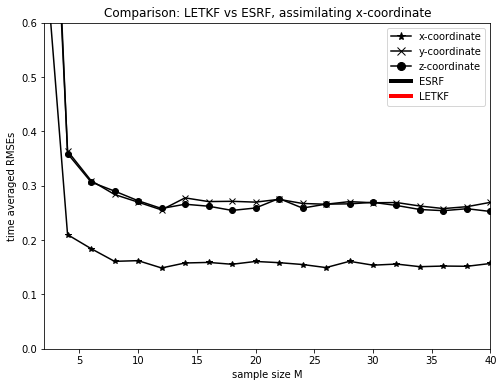

In [334]:
fig0a = plt.figure(figsize=(8,6))

plt.plot(m,rmse_x, 'k*-', label="x-coordinate")
plt.plot(m,rmse_y, 'kx-', label="y-coordinate")
plt.plot(m,rmse_z, 'ko-', label="z-coordinate")

# plt.plot(m,rmse_letkf[0], 'r*-', label="x-coordinate")
# plt.plot(m,rmse_letkf[1], 'rx-', label="y-coordinate")
# plt.plot(m,rmse_letkf[2], 'ro-', label="z-coordinate")

plt.xlim([2,40])
plt.ylim([0,0.6])
plt.xlabel("sample size M")
plt.ylabel("time averaged RMSEs")
plt.title("Comparison: LETKF vs ESRF, assimilating x-coordinate")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='*', color='k', label='x-coordinate',
                          markerfacecolor='k', markersize=8),
                   Line2D([0], [0], marker='x', color='k', label='y-coordinate',
                          markerfacecolor='k', markersize=8),
                   Line2D([0], [0], marker='o', color='k', label='z-coordinate',
                          markerfacecolor='k', markersize=8),
                   Line2D([0], [0], color='k', lw=4, label='ESRF'),
                   Line2D([0], [0], color='r', lw=4, label='LETKF')]
# plt.title("No data assimilation")
plt.legend(handles=legend_elements)
plt.show()

In [333]:
A = np.arange(25).reshape(5,5)
print(A)
D = np.ones(5).reshape(-1,1) * 3
print(D)
print(A+D)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[3.]
 [3.]
 [3.]
 [3.]
 [3.]]
[[ 3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12.]
 [13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22.]
 [23. 24. 25. 26. 27.]]
